# Susceptibility $\chi_0$ of non-interacting fermions

## Theory

The susceptibility $\chi$ of a system determines the linear-response to weak external fields and is given by the two particle response function,

$$
\chi_{\bar{a}b\bar{c}d}(\mathbf{r} - \mathbf{r}', \tau - \tau') = 
\langle \mathcal{T} (c^\dagger_a c_b)(\mathbf{r}, \tau) (c^\dagger_c c_d)(\mathbf{r}', \tau') \rangle 
- \langle c^\dagger_a c_b \rangle \langle c^\dagger_c c_d \rangle
\, ,
$$

where one pair of operators $c^\dagger_a c_b$ act at position $\mathbf{r}$ and imaginary time $\tau$ and a second pair of operators $c^\dagger_c c_d$ at $\mathbf{r}'$ and $\tau'$.

In the non-interacting limit the quartic expectation value can be decomposed using Wick's theorem and the non-interacting susceptibility takes the form

$$
\chi_0(\mathbf{r}, \tau) = 
- 
\langle \mathcal{T} c_b(\mathbf{r}, \tau) c^\dagger_a \rangle 
\langle \mathcal{T} c_d(-\mathbf{r}, -\tau) c^\dagger_c \rangle 
= - G_{b\bar{a}}(\mathbf{r}, \tau) G_{d\bar{c}}(-\mathbf{r}, -\tau)
\, ,
$$

i.e. it is just a direct product of two single particle Green's function in real-space.

Fourier transformed to momentum and Matsubara frequency space $\chi_0$ becomes a double convolution

\begin{equation}
  \chi_0(\mathbf{q}, i\omega_n) = 
    2\frac{1}{N}\sum_{\mathbf{k}, m} 
    G_0(\mathbf{k}, i\nu_m)G_0(\mathbf{k}+\mathbf{q}, i\nu_m + i\omega_n)
    \, ,
\end{equation}

where $\mathbf{q}$ and $\mathbf{k}$ are momenta and $i\omega_n$ and $i\nu_m$ are Bosonic and Fermionic Matsubara frequencies, respectively, and N the number of $\mathbf{k}$ points.

## Fast calculation using Fourier transform

To compute $\chi_0$ the fastest approach is to perform the direct product in real space and imaginary time above. However, we usually have the single particle Green's function in momentum and frequency $G(\mathbf{k}, i\nu_n)$ and are interested in the susceptibiltiy $\chi_0$ in the same space $\chi_0(\mathbf{q}, i\omega_n)$.

Therefore we compute $\chi_0$ by Fourier transforming the Green's function $G$ to imaginary time $\tau$ and real space $\mathbf{r}$, using fast Fourier transforms (FFT)

$$
G_0(\mathbf{r}, \tau) = 
  \mathcal{F}_{\{\mathbf{k}, i\nu_m\} \rightarrow \{\mathbf{r}, \tau\}} 
  \big\{ G_0(\mathbf{k}, i\nu_n) \big\}
  \, ,
$$

giving $\chi_0$ as the simple product

$$
\chi_0(\mathbf{r},\tau) = 2 G_0(\mathbf{r},\tau)G_0(-\mathbf{r},\beta -\tau)
\, ,
$$

where we have dropped orbital indices and added a factor of 2 for spin. Finally we Fourier transform $\chi_0$ back to momentum and Matsubara frequency

$$ 
  \chi_0(\mathbf{q},i\omega_n) \equiv 
  \mathcal{F}_{\{\mathbf{r},\tau\} \rightarrow \{\mathbf{q}, i\omega_n\}} 
  \big\{ \chi_0(\mathbf{r}, \tau) \big\}
  \, .
$$

## Goals and questions

The goal of this notebook is to compute and study $\chi_0$. We will investigate the following questions:

- How many operations are saved by using fast Fourier transforms rather than evaluating the convolutions directly?


- For the half-filled square lattice, at what momenta $\mathbf{q}$ does $\chi_0$ have a maximum at zero frequency?


- How is the position of the maximum related to the Fermi surface?
   

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from triqs.plot.mpl_interface import plt, oplot

import numpy as np
from triqs.gf import *

## Compute the susceptibility $\chi_0(\mathbf{q}, i\omega_n)$

The effective Fourier transform based routine for computing the susceptibility is implemented in TPRF in the function `triqs_trpf.lattice_utils.imtime_bubble_chi0_wk`. To construct $\chi_0$ as defined above it can be called using the lattice Green's function `g0_wk` from the previous notebook.

```python
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
chi0_wk = 2 * imtime_bubble_chi0_wk(g0_wk, nw=100) # Factor of 2 for spin
```

Read `g0_wk` from file, compute `chi0_wk`, and store it to disk in the file `chi0_wk.h5` so that we can reuse it later.

In [2]:
# Write your code here

from h5 import HDFArchive

with HDFArchive("g0_wk.h5",'r') as R:
    g0_wk = R['g0_wk']

from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
chi0_wk = 2 * imtime_bubble_chi0_wk(g0_wk, nw=16)

# Save it for later reuse
with HDFArchive("chi0_wk.h5", "w") as R:
    R['chi0_wk'] = chi0_wk


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 2.5
nk    = 16384
nw    = 64
norb  = 1

Approx. Memory Utilization: 0.06 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)


Starting serial run at: 2023-08-24 17:40:29.549022


--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


## Static susceptibility $\chi_0(\mathbf{q}, \omega=0)$ and perfect nesting

As you saw in the previous notebook, the square lattice with nearest-neighbour hopping $t$ has a perfectly nested Fermi surface at half-filling. In other words, large parts of the Fermi surface are mapped on to each other by a single momentum transfer $\mathbf{Q}$, called the *nesting vector*. Go back to the previous notebook and the plot of $-\frac{1}{\pi} Im G_0(\mathbf{k}, i\omega_0)$ and remind your self about the nesting vector $\mathbf{Q} = (\pi, \pi)$. The perfect nesting greatly enhances the susceptibility $\chi_0$ which has a dominant peak at $\chi_0(\mathbf{Q}, \omega=0)$.

Analytically this can be derived using the expression for the Greens function and performing the Matsubara frequency sum, giving

\begin{equation}
  \chi_0(\mathbf{q}, \omega=0) = 
    2\frac{1}{N}\sum_{\mathbf{k}, m} 
    G_0(\mathbf{k}, i\nu_m)G_0(\mathbf{k}+\mathbf{q}, i\nu_m)= \frac{2}{N}\sum_{\mathbf{k}}\frac{f(\epsilon(\mathbf{k}))-f(\epsilon(\mathbf{k+q}))}{\epsilon(\mathbf{k})-\epsilon(\mathbf{k+q})}.
\end{equation}

For the square lattice the dispersion

$$\epsilon(\mathbf{k}) = -2t (\cos(k_x) + \cos(k_y) ) $$

has the property that $\epsilon(\mathbf{k+Q})=-\epsilon(\mathbf{k})$ for $\mathbf{Q}=(\pi,\pi)$. Hence, at $\mathbf{q} = \mathbf{Q}$ we get

\begin{equation}
  \chi_0(\mathbf{Q}, \omega=0) = 
    \frac{1}{N}\sum_{\mathbf{k}}\frac{\tanh(\beta\epsilon(\mathbf{k})/2)}{\epsilon(\mathbf{k})}
\end{equation}
which diverges as $T \rightarrow 0$ (i.e. when $\beta \rightarrow \infty$).

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1

Investigate the momentum structure of the susceptibility $\chi_0$ by making a two-dinensional color plot of $\chi_0(\mathbf{q}, \omega=0)$ over the Brillouin zone.

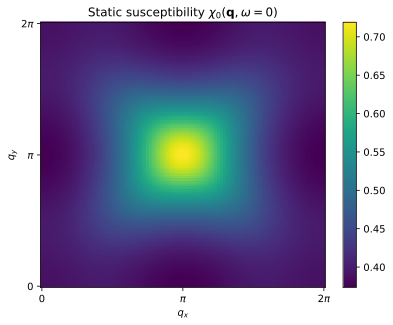

In [3]:
# Write your code here

k = np.linspace(0, 2*np.pi, num=100, endpoint=True)
kx, ky = np.meshgrid(k, k)

chi_interp = np.vectorize(lambda kx, ky: chi0_wk(0, (kx, ky, 0)).real)

plt.pcolormesh(kx, ky, chi_interp(kx, ky), rasterized=True)

plt.title('Static susceptibility $\chi_0(\mathbf{q}, \omega=0)$')
ticks, labels = [0, np.pi, 2*np.pi], [r"0",r"$\pi$",r"$2\pi$"]
plt.xticks(ticks, labels); plt.yticks(ticks, labels);
plt.xlabel(r'$q_x$'); plt.ylabel(r'$q_y$')
plt.colorbar();

**Hint**: Use the code to plot the dispersion $\epsilon(\mathbf{k})$ in the previous notebook as a starting point.

**Questions**

- Does the extrema of $\chi_0$ appear at the suggested nesting vector $\mathbf{Q}$?
- Is it possible to see any additional momentum structure in $\chi_0$?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercice 2

Plot the static susceptibility $\chi_0(\mathbf{q}, \omega=0)$ along the high symmetry path
$\Gamma \rightarrow X \rightarrow M \rightarrow \Gamma$ in the Brillouin zone. 

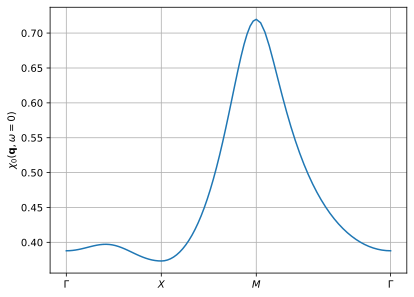

In [4]:
# Write your code here

G = [0.0, 0.0, 0.0]
X = [0.5, 0.0, 0.0]
M = [0.5, 0.5, 0.0]

path = [(G, X), (X, M), (M, G)]

from triqs_tprf.lattice_utils import k_space_path

k_vecs, k_plot, k_ticks = k_space_path(path, num=32, bz=chi0_wk.mesh[1].bz)
    
chi0_k_interp = np.vectorize(lambda k : chi0_wk(0, k).real, signature='(n)->()')
 
plt.plot(k_plot, chi0_k_interp(k_vecs))
plt.xticks(k_ticks, labels=[r'$\Gamma$', '$X$', '$M$', r'$\Gamma$'])
plt.ylabel(r'$\chi_0(\mathbf{q},\omega=0)$'); plt.grid()

**Hint**: Re-purpose the code for the high symmetry path plot of $\epsilon(\mathbf{k})$ in the previous notebook.

**Questions**

- How is the perfect nesting manifest in the plot?
- Is it possible to understand also the additional fine structure in $\chi_0$?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3

So far you we have only been studying the susecptibility $\chi_0$ in the "static" zero frequency limit $\omega=0$. However, the Matsubara frequency dependence of $\chi_0(\mathbf{q}, i\omega_n)$ encodes information about the dynamical response properties of the system.

Here we will take a close look at the frequency depdendence at the high-symmetry momentum points. 

To get the Matsubara frequency dependent suceptibility at a given momentum $k$ we use the partial interpolation feature of TRIQS using the keyword `all` to select all Matsubara frequencies at a fixed momenta:

```python
k = np.array([np.pi, 0., 0.]) # A vector in momentum space
chi0_at_k_w = chi0_wk(all, k) # Get the frequency dependence of \chi_0 at k
```

Plot the frequency dependence of the susceptibility $\chi_0(\mathbf{q}, i\omega_n)$ for the high symmetry points $\Gamma$, $X$, $M$ in momentum space.

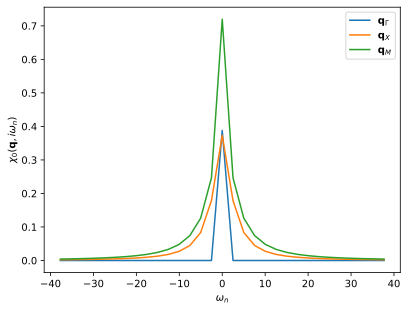

In [5]:
# Write your code here

k_G = np.array([0., 0., 0.]) * 2 * np.pi
k_X = np.array([0.5, 0., 0.]) * 2 * np.pi
k_M = np.array([0.5, 0.5, 0.]) * 2 * np.pi

k_pts = [k_G, k_X, k_M]
labels = ['$\mathbf{q}_\Gamma$', '$\mathbf{q}_X$', '$\mathbf{q}_M$']

for k, label in zip(k_pts, labels):
    oplot(chi0_wk(all, k), mode='R', label=label)

plt.ylabel(r'$\chi_0(\mathbf{q}, i\omega_n)$');

**Questions**

- Does the large static susceptibilty at $\mathbf{Q} = (\pi, \pi)$ manifest itself at all frequencies?
- How does the frequency behaviour at the $M$ point differ to the $X$ and $\Gamma$ points?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 4

Let's check the analytical expression for the nesting response given above 

\begin{equation}
  \chi_0(\mathbf{Q}, \omega=0) = 
    \frac{1}{N}\sum_{\mathbf{k}}\frac{\tanh(\beta\epsilon(\mathbf{k})/2)}{\epsilon(\mathbf{k})}
\end{equation}

using the numerical dispersion $\epsilon(k)$. 

Go back to the first notebook where you constructed the dispersion and write it to disk and read it back into this notebook.

The analytical formula can be implemented in numpy using
```
kmesh = e_k.mesh
beta = chi0_wk.mesh[0].beta
chi_Q_ref = np.sum(np.nan_to_num(np.tanh(e_k.data.real * beta/2) / e_k.data.real, nan=0.)) / len(kmesh) 
```

Make a combined plot of the Matsubara frequency dependent susceptibility at $\mathbf{Q}$ and the analytical value of the static response. 

/tmp/ipykernel_36337/228374747.py:8: RuntimeWarning: invalid value encountered in divide
  chi_Q_ref = np.sum(np.nan_to_num(np.tanh(e_k.data.real * beta/2) / e_k.data.real, nan=0.)) / len(kmesh)


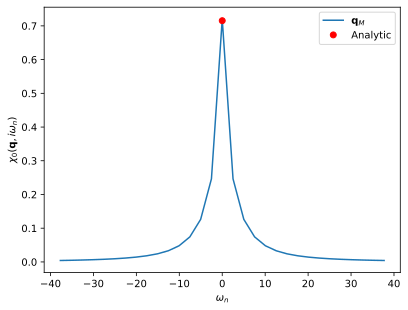

In [6]:
# Write your code here

with HDFArchive("e_k.h5",'r') as R:
    e_k = R['e_k']

kmesh = e_k.mesh
beta = chi0_wk.mesh[0].beta
chi_Q_ref = np.sum(np.nan_to_num(np.tanh(e_k.data.real * beta/2) / e_k.data.real, nan=0.)) / len(kmesh) 

oplot(chi0_wk(all, k_M), mode='R', label='$\mathbf{q}_M$')
plt.plot(0, chi_Q_ref, 'ro', label='Analytic')

plt.ylabel(r'$\chi_0(\mathbf{q}, i\omega_n)$'); plt.legend();

**Question**

- Does the analytic formula agree with the numerical susceptibility at $\mathbf{Q}$?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 5

From the Matsubara frequency dependence of the susceptibility it is also possible to (approximately) determine the real frequency behaviour using analytical continuation.

TRIQS provides Padé based routines for analytical continuation as a member function of a real-fequency Green's function:

```python
fmesh = MeshReFreq(w_min=-10, w_max=10, n_w=100)
chi_f = Gf(mesh=fmesh, target_shape=chi0_wk.target_shape)
chi_f.set_from_pade(chi0_wk(all, k), n_points=32, freq_offset=0.1)
```

Use this to plot the real-frequency dependence of the susceptibility for the high symmetry points $\Gamma$, $X$, and $M$ in the Brillouin zone.

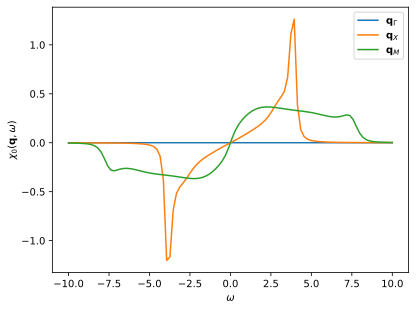

In [7]:
# Write your code here

fmesh = MeshReFreq(w_min=-10, w_max=10, n_w=100)
chi_f = Gf(mesh=fmesh, target_shape=chi0_wk.target_shape)

for label, k in zip(labels, [k_G, k_X, k_M]):
    chi_f.set_from_pade(chi0_wk(all, k), n_points=16, freq_offset=0.1)
    oplot(chi_f, mode='I', label=label)
    
plt.ylabel(r'$\chi_0(\mathbf{q}, \omega)$');

**Question**

- Is the largest peak value in real-frequency correlated with the largest static response?
- Why is $\chi_0$ approximately equal to zero at $\Gamma$?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 6

While analytical continuation is numerically unstable in general, it can be useful to get a rough picture of the real-frequency dependence, as we saw above.

In TPRF there is a helper routine `triqs_tprf.lattice_utils.pade_analytical_continuation_wk` that performs analytical continuation on lattice response functions for all momenta at once through:

```python
from triqs_tprf.lattice_utils import pade_analytical_continuation_wk
chi0_fk = pade_analytical_continuation_wk(chi0_wk, fmesh, n_points=32, freq_offset=0.1)
```

Make a color plot of `chi0_fk` along the high symmetry path in k-space with the frequency on the y-axis.

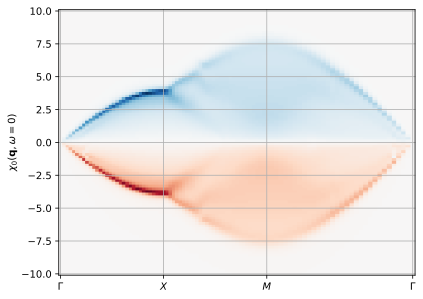

In [8]:
# Write your code here
     
from triqs_tprf.lattice_utils import pade_analytical_continuation_wk
chi0_fk = pade_analytical_continuation_wk(chi0_wk, fmesh, n_points=16, freq_offset=0.1)

f = np.array([ float(f) for f in fmesh ])
chi0_fk_interp = np.vectorize(lambda k : np.squeeze(chi0_fk(all, k).data).imag, signature='(n)->(m)')

plt.pcolormesh(k_plot, f, chi0_fk_interp(k_vecs).T, rasterized=True, cmap='RdBu')

plt.xticks(k_ticks, labels=[r'$\Gamma$', '$X$', '$M$', r'$\Gamma$'])
plt.ylabel(r'$\chi_0(\mathbf{q},\omega=0)$'); plt.grid();

**Questions**

- Where is the strongest response in momentum and frequency?
- How can one see where the static susceptibilitiy has its maximum?